## Degenerate Unmixing Estimation Technique

People don't always listen to each other... &#128071;

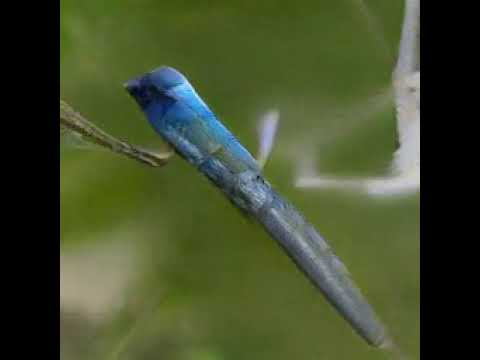

In [ ]:
from IPython.display import YouTubeVideo

vid = YouTubeVideo("SoGjqo-QfYM")
display(vid)

In this notebook you will implement the Degenerate Unmixing Estimation Technique (DUET) for separating mixtures of speech signals.

### 1. Mixture signal

In [ ]:
import matplotlib
import IPython.display as ipd
import numpy as np
import soundfile as sf 
import matplotlib.pyplot as plt
import scipy as sp
import librosa
import librosa.display
import os
from utils import plot_recording_config
from DUET_config import q_m1, q_m2, q_s

We are going to unmix a stereophonic anechoic mixture of $J=3$ speech source signals using the DUET algorithm. We first load the wav file `mix.wav` which contains the mixture. 

Text(0, 0.5, 'amplitude')

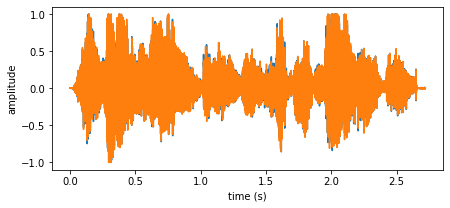

In [ ]:
x, fs = sf.read('data/mix.wav')
T = x.shape[0]
time_vec = np.arange(T)/fs

plt.figure(figsize=(7,3))
plt.plot(time_vec, x)
plt.xlabel('time (s)')
plt.ylabel('amplitude')

Listen to the mixture signal.

In [ ]:
ipd.Audio([x[:,0], x[:,1]], rate=fs) 

### 2 DUET - Practice

**Acknowledgements**: Some pieces of code are inspired from [The Northwestern University Source Separation Library (nussl)](https://github.com/interactiveaudiolab/nussl).

---

You will now implement the DUET algorithm, as studied during the lecture. You are encouraged to look back at the slides while solving the exercises.

#### 2.1 Local mixing parameters computation

**Exercise:**

Complete the next cell to:

- compute the STFTs $X_1(f,n)$ and $X_2(f,n)$ of the left and right microphone signals, respectively.

- compute the local attenuation coefficients in dB:

    $$\hat{a}_{dB}(f,n) = 20 \log_{10} \hat{a}(f,n),$$

    where 

    $$ \hat{a}(f,n) = \left|\frac{X_{2}(f,n) + \epsilon}{X_{1}(f,n) + \epsilon}\right|,$$

    and $\epsilon = 10^{-10}$ is used to avoid dividing by zero.

- compute the local relative delay coefficients (apply the normalization only for $f > 0$):

$$\hat{\delta}(f,n) = -\frac{1}{2 \pi f/L}\arg\left(\frac{X_{2}(f,n)}{X_{1}(f,n)}\right).$$ 

__hint__: Use 'np.angle' to compute the argument of a complex number.

In [ ]:
wlen_sec = 32e-3 # STFT window length in seconds
hop_percent = .5 # hop size as a percent of the window length
wlen = int(wlen_sec*fs) # window length in samples
wlen = int(np.power(2, np.ceil(np.log2(wlen)))) # next power of 2
F = wlen//2+1 # number of non-redundant frequency bins
hop = int(hop_percent*wlen) # hop size in samples
win = np.sin(np.arange(.5,wlen-.5+1)/wlen*np.pi); # sine analysis window

X_L = librosa.stft(x[:,0], n_fft=wlen, hop_length=hop, win_length=wlen, window=win)
X_R = librosa.stft(x[:,1], n_fft=wlen, hop_length=hop, win_length=wlen, window=win)

F, N = X_L.shape

########## TODO ###########

inter_channel_ratio = (X_R + 1e-10) / (X_L + 1e-10)

attenuation = np.abs(inter_channel_ratio) # relative attenuation between the two channels
attenuation_dB = 20*np.log10(attenuation) # relative attenuation in dB

f_vec = 2 * np.pi * np.arange(F) / wlen # contains 2 pi f / L for f = 0, 1, ..., F-1
f_mat = f_vec[:, np.newaxis]

relative_delay = -np.angle(inter_channel_ratio) # relative delay
relative_delay[1:,:] = relative_delay[1:,:] / f_mat[1:,:]  # relative delay

##########################

#### 2.2 2D histogram computation and peak picking

In the following cell, we plot a 2D histogram of the local mixing parameters $\Big\{ \big(\hat{a}_{dB}(f,n), \hat{\delta}(f,n)\big) \Big\}_{f,n}$ that you extracted. 

**Question**: What do you observe?

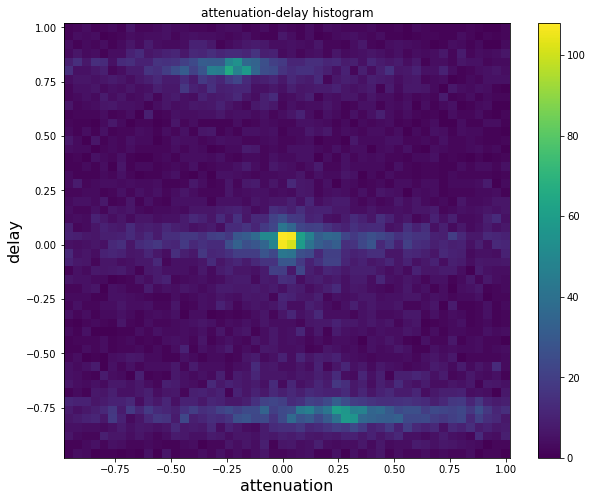

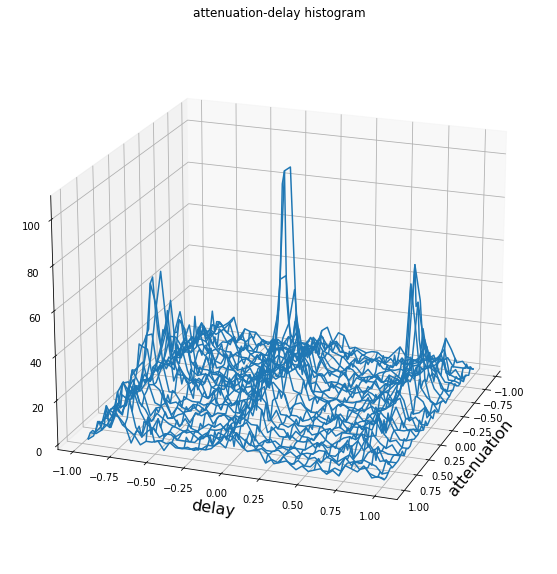

In [ ]:
nbins_att = 50 # the number of bins for the attenuation dimension
nbins_delay = 50 # the number of bins for the delay dimension
bins_array = np.array([nbins_att, nbins_delay])

range_array = np.array([[-1, 1], [-1, 1]]) #The leftmost and rightmost edges of the bins along each dimension.
# All values outside of this range will be considered outliers and not counted in the histogram.

# compute the histogram
histogram, atn_bins, delay_bins = np.histogram2d(attenuation_dB.flatten(), relative_delay.flatten(), 
                                                 bins=bins_array, range=range_array)

atn_tile = np.tile(atn_bins[1:], (nbins_att, 1)).T
delay_tile = np.tile(delay_bins[1:].T, (nbins_delay, 1))

fig = plt.figure(figsize=(10,8))
plt.pcolormesh(atn_tile, delay_tile, histogram, shading='auto')
plt.xlabel('attenuation', fontsize=16)
plt.ylabel('delay', fontsize=16)
plt.title('attenuation-delay histogram')
plt.axis('tight')
plt.colorbar()

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(atn_tile, delay_tile, histogram, rstride=2, cstride=2)
plt.xlabel('attenuation', fontsize=16)
plt.ylabel('delay', fontsize=16)
plt.title('attenuation-delay histogram')
plt.axis('tight')
ax.view_init(20, 20)

In the following cell, we extract the peaks of the 2D histogram in order to estimate the mixing parameters $\{(\hat{a}_j, \hat{\delta}_j)\}_{j=1}^J$.

In [ ]:
from utils import find_peak_indices

J = 3 # number of source signals

peak_indices = find_peak_indices(histogram, J, threshold=0.2, min_dist=[5,5])

atn_indices = [x[0] for x in peak_indices]
delay_indices = [x[1] for x in peak_indices]

atn_peak_dB = atn_bins[atn_indices] # attenuation estimates in dB scale, shape (J,)
atn_peak = 10**(atn_peak_dB/20)  # attenuation estimates in linear scale, shape (J,)

delay_peak = delay_bins[delay_indices] # relative delay estimates, shape (J,)

print('Estimated attenuations (ILD): %.2f, %.2f, %.2f' % tuple(atn_peak))
print('Estimated delays (ITD): %.2f, %.2f, %.2f' % tuple(delay_peak))

Estimated attenuations (ILD): 1.00, 0.97, 1.02
Estimated delays (ITD): 0.00, 0.76, -0.80


We can compare the estimated values with the true ones from the definition of the recording configuration in `DUET_config.py`:

In [ ]:
from DUET_config import delta, a
print('Attenuations: %.2f, %.2f, %.2f' % tuple(a))
print('Delays: %.2f, %.2f, %.2f' % tuple(delta))

Attenuations: 1.03, 1.00, 0.97
Delays: -0.80, 0.00, 0.80


#### 2.3 Binary masking

Once the peaks have been identified, our goal is to determine the time–frequency masks which will separate each source from the mixtures. This is achieved by assigning each time–frequency point $(f,n)$ to the source of index $j \in \{1,...,J\}$ whose peak $(\hat{a}_j, \hat{\delta}_j)$ is closest to the local parameter estimates $\big(\hat{a}(f,n), \hat{\delta}(f,n)\big)$.

More precisely, we build the time-frequency masks as follows:

$$ M_j(f, n) =  \begin{cases}
1 & \text{if } \mathcal{J}(f,n) = j \\
0 & \text{otherwise} \\
\end{cases},$$

where $\mathcal{J}(f,n)$ is defined by

$$ \mathcal{J}(f,n) = \underset{j \in \{1,...,J\}}{\operatorname{argmin}} \left| \hat{a}_j  \exp\left({-\imath 2 \pi \frac{f}{L} \hat{\delta}_j}\right) - \hat{a}(f,n) \exp\left({-\imath 2 \pi \frac{f}{L} \hat{\delta}(f,n)}\right) \right|^2 $$

In the following cell, we compute the masks by applying this procedure. In particular, we use ```np.argmin``` to find the source index that minimizes the above cost.

In [ ]:
masks = np.zeros((F, N, J))

f_vec = 2 * np.pi * np.arange(F) / wlen 
f_mat = f_vec[:, np.newaxis]

for f in np.arange(F):
    for n in np.arange(N):
        
        cost = np.abs(atn_peak * np.exp(-1j * f_mat[f] * delay_peak) - 
                      attenuation[f,n] * np.exp(-1j * f_mat[f] * relative_delay[f,n]) )**2
        
        j = np.argmin(cost)
        masks[f,n,j] = 1

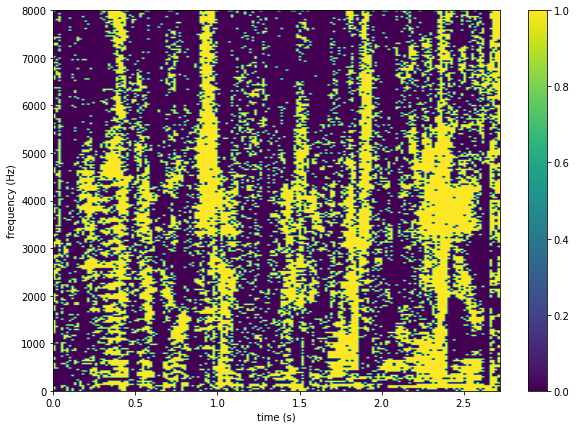

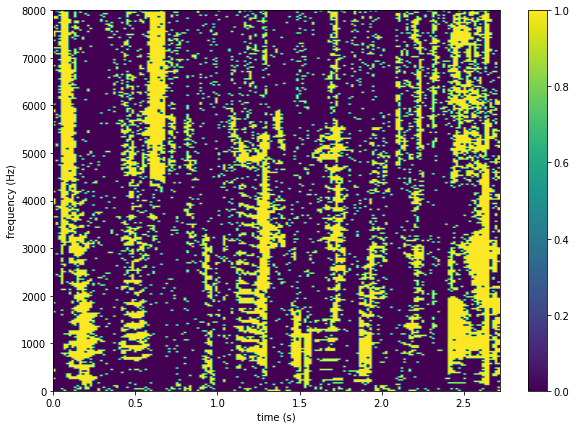

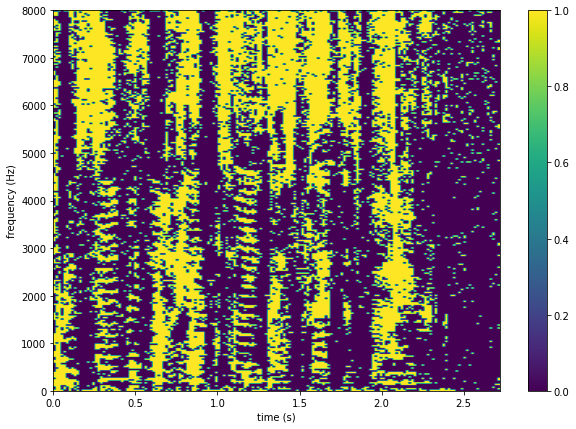

In [ ]:
# Plot the masks
for j in np.arange(J):   
    plt.figure(figsize=(10,7))
    plt.imshow(masks[:,:,j], origin='lower', aspect='auto', extent=[0, (N-1)*hop/fs, 0, fs/2])
    plt.xlabel('time (s)')
    plt.ylabel('frequency (Hz)')
    plt.colorbar()

#### 2.4 Source separation

**Exercise:** 

Apply the binary masks to the mixture (use the left microphone signal only) in order to compute the STFT of the individual source signals and recover the waveforms by computing the inverse STFT (use `librosa.istft`, with the same parameters as used when computing the STFT of the mixture).

In [ ]:
s_est = np.zeros((T,J)) # estimated waveform of the J sources

########## TODO ###########

for j in np.arange(J):
    s_est[:, j] = librosa.istft(np.where(masks[:,:,j], X_L, 0), n_fft=wlen, hop_length=hop, win_length=wlen, window=win)
    
##########################

Listen to the separated sources.

In [ ]:
ipd.Audio(s_est[:, 0], rate=fs) 

In [ ]:
ipd.Audio(s_est[:, 1], rate=fs) 

In [ ]:
ipd.Audio(s_est[:, 2], rate=fs) 